In [1]:
import os
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings

import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore

from IPython.display import Image, display


In [2]:
load_dotenv()
os.environ['GEMINI_API_KEY']=os.getenv("GEMINI_API_KEY")

The embedding model and LLM model do not have to be the same or from the same provider (e.g., you can use a Google embedding model and an OpenAI or Mistral LLM). However, they should be conceptually compatible, meaning:

Compatibility Guidelines (when mixing embedding model and LLM):


- Same or aligned language: Both should support the same language (e.g., English).

- Tokenization logic: While not strictly required, embeddings generated with token boundaries similar to those the LLM expects can help semantic similarity comparisons be more meaningful.

- Semantic representation quality: The embedding model should generate vectors that capture enough contextual richness for the LLM to reason over.

In [3]:
# Using Google's text-embedding-004 for embeddings and gemini-1.5-flash for LLM — both from Google, ensuring compatibility in tokenization and embedding logic.

# We'll load the following pdf document into a vector datastore
RAG_LOOKUP_FILE_PATH='data/2024-03-21_AIP_Basic_dtd_3-21-24.pdf'
EMBEDDING_MODEL_NAME='models/text-embedding-004'

# We'll use this LLM model 
GENAI_MODEL_NAME='gemini-1.5-flash'


In [4]:
# Load PDF 
loader = PyPDFLoader(RAG_LOOKUP_FILE_PATH)
docs = loader.load()

In [5]:
# show the first 10 docs
docs[:10]

[Document(metadata={'producer': 'Adobe Acrobat Pro (32-bit) 23 Paper Capture Plug-in', 'creator': 'BroadVision, Inc.', 'creationdate': '2024-03-11T08:56:26-04:00', 'author': 'Mission Support Services, Policy', 'moddate': '2024-03-25T15:53:46-04:00', 'subject': 'Aeronautical Information Pulication (AIP) 28th Edition', 'title': 'AIP Basic dtd 3-21-24', 'source': 'data/2024-03-21_AIP_Basic_dtd_3-21-24.pdf', 'total_pages': 2075, 'page': 0, 'page_label': '1'}, page_content='AIP \nAERONAUTICAL INFORMATION PUBLICATION \nUNITED STATES OF AMERICA \nTWENTY-EIGHTH EDITION \n21 MARCH 2024 \nCONSULT NOTAM FOR LATEST INFORMATION \nDEPARTMENT OF TRANSPORTATION \nFEDERAL AVIATION ADMINISTRATION'),
 Document(metadata={'producer': 'Adobe Acrobat Pro (32-bit) 23 Paper Capture Plug-in', 'creator': 'BroadVision, Inc.', 'creationdate': '2024-03-11T08:56:26-04:00', 'author': 'Mission Support Services, Policy', 'moddate': '2024-03-25T15:53:46-04:00', 'subject': 'Aeronautical Information Pulication (AIP) 28th 

In [6]:
# create a splitter
splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,#hyperparameter
    chunk_overlap=50 #hyperparemeter
)

In [7]:
# split the documents
split_docs = splitter.split_documents(docs)
len(split_docs)

10453

In [8]:
# Get the embeddings model
embeddings = GoogleGenerativeAIEmbeddings(model=EMBEDDING_MODEL_NAME, google_api_key=os.environ["GEMINI_API_KEY"])

In [9]:
# he GoogleGenerativeAIEmbeddings object from LangChain does not expose the embedding size (i.e., dimensionality) directly as an attribute like .embedding_size.
# However, you can programmatically determine it by running a quick dummy embedding and checking the length of the result

embedding_dim = len(embeddings.embed_query("test"))
print(f"Embedding size: {embedding_dim}")

Embedding size: 768


In [10]:
# Create the vector store 
# (InMemory store in FAISS)

index=faiss.IndexFlatL2(embedding_dim)

#vectorstore = FAISS.from_documents(split_docs, embeddings)

vector_store=FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

retriever = vector_store.as_retriever()

In [11]:
ids = vector_store.add_documents(split_docs)

# display the first 10 ids
ids[:10]

['069c6dd4-7da1-4022-b39e-75be5b2e098f',
 '90acda33-9f08-4c12-a4ff-0ab15552d66e',
 '3ce3169b-4a0e-476f-9a19-1dbe0a486a75',
 'eba2e0c0-3544-4487-b942-752a82f79576',
 '9a4ecc86-2cb7-4cb8-85a1-c9e868663c85',
 '58b37e3e-6b4a-4d00-885c-126ed70d8668',
 'b8448c49-6653-43a1-9acc-9e8cebaabf8a',
 'a3332521-efaa-4dcc-9705-9806c77a31ad',
 '18f21b78-00f9-4a3a-9160-d1e26b245b46',
 'af2587ab-8559-4b08-a5d1-949126b23c00']

In [12]:
from itertools import islice

def slice_dict(d, start, stop):
    return dict(islice(d.items(), start, stop))

slice_dict(vector_store.index_to_docstore_id,1,10)

{1: '90acda33-9f08-4c12-a4ff-0ab15552d66e',
 2: '3ce3169b-4a0e-476f-9a19-1dbe0a486a75',
 3: 'eba2e0c0-3544-4487-b942-752a82f79576',
 4: '9a4ecc86-2cb7-4cb8-85a1-c9e868663c85',
 5: '58b37e3e-6b4a-4d00-885c-126ed70d8668',
 6: 'b8448c49-6653-43a1-9acc-9e8cebaabf8a',
 7: 'a3332521-efaa-4dcc-9705-9806c77a31ad',
 8: '18f21b78-00f9-4a3a-9160-d1e26b245b46',
 9: 'af2587ab-8559-4b08-a5d1-949126b23c00'}

## Now we'll create the RAG Chain and Non-RAG Chain

In [13]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


In [14]:
# Model
model = ChatGoogleGenerativeAI(model=GENAI_MODEL_NAME, google_api_key=os.environ['GEMINI_API_KEY'])


In [15]:
model

ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x16bd48aa0>, default_metadata=(), model_kwargs={})

In [16]:
# Prompt template from LangChain Hub
prompt = hub.pull("rlm/rag-prompt")

In [17]:
# Output parsing
parser = StrOutputParser()

In [18]:
# Formatter
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

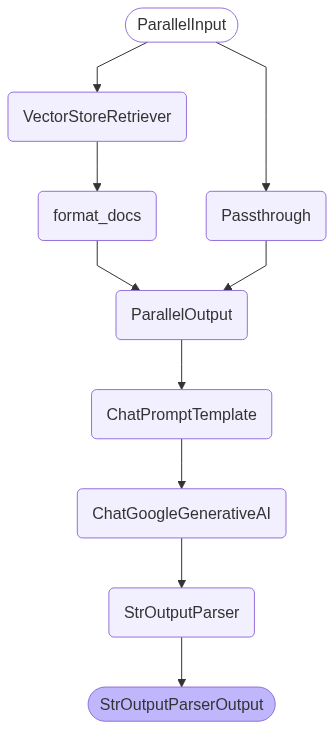

In [19]:
# RAG chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | parser
)

# display the chain
display(Image(rag_chain.get_graph().draw_mermaid_png()))

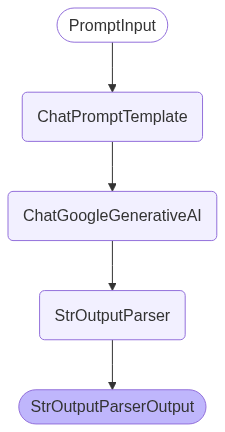

In [20]:
# Non-RAG chain
from langchain_core.prompts import ChatPromptTemplate
base_prompt = ChatPromptTemplate.from_template("Answer the following question: {question}")
non_rag_chain = (
    base_prompt
    | model
    | parser
)

# display the chain
display(Image(non_rag_chain.get_graph().draw_mermaid_png()))

In [21]:
question1 = "What does the equipment code 'Z' signify in Item 10a of the ICAO flight plan?"
##question="How should a delay in departure be communicated in an ICAO flight plan filed with the FAA?"
question2="What PBN codes are required for filing an RNP 1 SID in the U.S.?"
question3="What are the FAA's guidelines for UAS operators regarding flight service briefings?"

questions = [question1, question2, question3]
for question in questions:
    print("\n"+question)
    print("=== Non-RAG Output ===")
    print(non_rag_chain.invoke({"question": question}))

    print("\n=== RAG Output ===")
    print(rag_chain.invoke(question))

    print("="*100)



What does the equipment code 'Z' signify in Item 10a of the ICAO flight plan?
=== Non-RAG Output ===
In ICAO flight plans, the equipment code 'Z' in Item 10a signifies that the aircraft is **equipped with a transponder with altitude reporting capability**.

=== RAG Output ===
In Item 10a of the ICAO flight plan, 'Z' signifies that other equipment or capabilities are carried.  These must be specified in Item 18, preceded by COM/, NAV/, and/or DAT as appropriate.  'Z' itself doesn't define the specific equipment.

What PBN codes are required for filing an RNP 1 SID in the U.S.?
=== Non-RAG Output ===
There isn't a single, universally applicable set of PBN codes specifically for filing an RNP 1 SID in the U.S.  The required PBN codes depend on the specific SID's design and the navigational aids used.  An RNP 1 SID might utilize various PBN approaches, including:

* **RNAV (RNP) 1:** This is the basic designation, but it doesn't specify the underlying navigation technology.
* **GPS:**  If